In [4]:
from tqdm import tqdm as tqdm
import pandas as pd
import numpy as np
import subprocess
import random
import glob
import math

import gzip

import os

from ipynb.fs.full.bee_metagenomics import write_bs_ids_file, read_bs_ids_file, get_status_job_array_ids, parse_kreport # need to restart kernel when adding new functions

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

1. select 20 colonies for validation
2. compare our trimming approach (cutadapt vs. trimmomatic)
3. compare choice of reference genomes (1 vs. 3 refs) and alignment method (bowtie2 vs bwa-mem2)

In [51]:
working_path = '/cluster/raid/home/f80878961/beestrong/'
tlf_path = '{}tlf/'.format(working_path)
pheno_df = pd.read_csv('{}BeeStrong_metadata.csv'.format(tlf_path))
data_path = '{}data/'.format(working_path)

sra_path = '{}BeeStrongSRA/'.format(data_path) 
pp_path = '{}pp/'.format(data_path)

shared_data_path = '/cluster/raid/home/f80878961/data/'
bwamem2_path = '{}bwamem2/'.format(data_path)

sample_SRA_file = '{}sample_SRA.csv'.format(tlf_path)
bs_sra_df = pd.read_table(sample_SRA_file)
script_path = "/cluster/raid/home/f80878961/scripts/tmp_scripts/"

bs_ids_file = '{}sampled_bs_ids.txt'.format(data_path)
array_id2bs_id, bs_id2array_id = read_bs_ids_file(bs_ids_file)

### lib

In [6]:
def write_preprocessing_script(script_fn, array_str, node_str):
    runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STRING
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --nodelist=NODE_STRING
#SBATCH --mem=100g
#SBATCH --time=6:00:00
#SBATCH --job-name=pp
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

module purge
modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
ml SRA-Toolkit
ml cutadapt
ml FastQC
ml Trimmomatic/0.39

# file listing all BeeStrong ids (bs_id) for parallel computing
bs_ids_file=$1
sra_path=$2
fastq_path=$3
sample_SRA_file=$4
adaptor_file=$EBROOTTRIMMOMATIC/adapters/TruSeq3-PE-2.fa

# work on scratch node is better when lots of I/O operations
node_scratch=/scratch/${USER}/tmp_${SLURM_ARRAY_JOB_ID}_${SLURM_ARRAY_TASK_ID}/
mkdir -p $node_scratch

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})

echo "1. find all SRA ids corresponding to the bs_id and copy them to the scrach node"
sra_ids=()
for sra in $(grep $bs_id $sample_SRA_file | cut -f 2); do
    sra_ids+=($sra)
    
    # download the SRA file on the go
    if [[ -d "$sra_path/$sra" || -f "$sra_path/$sra.sra" ]]; then
        echo "Skipping $sra: already downloaded"
    else
        echo "downloading $sra"
        prefetch -O $sra_path $sra
    fi
    cp -r $sra_path$sra $node_scratch
done

fastq_1=$node_scratch${bs_id}_1.fastq
fastq_2=$node_scratch${bs_id}_2.fastq
    
if [[ -f "$fastq_path${bs_id}_1.fastq" || -f "$fastq_path${bs_id}_2.fastq" ]]; then
    echo "2. copying ${bs_id}_x.fastq to $node_scratch: fastq already dumped"
    cp -f "$fastq_path${bs_id}_1.fastq" $fastq_1
    cp -f "$fastq_path${bs_id}_2.fastq" $fastq_2
    ls $fastq_1
    ls $fastq_2
else
    echo "2. concatenate fastq from multiple SRA files"
    # initiate fastq files
    touch $fastq_1
    touch $fastq_2
    for sra in "${sra_ids[@]}"; do
        fasterq-dump $node_scratch$sra -O $node_scratch
        cat ${node_scratch}${sra}_1.fastq >> $fastq_1
        cat ${node_scratch}${sra}_2.fastq >> $fastq_2
        rm -f ${node_scratch}${sra}_1.fastq
        rm -f ${node_scratch}${sra}_2.fastq
    done
fi

echo "3. trim poly-G tails with cutadapt"
fastq_1_t=$node_scratch${bs_id}_1_cut.fastq
fastq_2_t=$node_scratch${bs_id}_2_cut.fastq

# cutadapt -a "G{10}" -A "G{10}" -m 50 -o $fastq_1_t -p $fastq_2_t $fastq_1 $fastq_2
cutadapt -a "file:$adaptor_file" -A "file:$adaptor_file" -a "G{10}" -A "G{10}" -m 50 -o $fastq_1_t -p $fastq_2_t $fastq_1 $fastq_2

# mv -f $fastq_1_t $fastq_1
# mv -f $fastq_2_t $fastq_2

## extra steps to compare with trimmomatic approach
fastq_1_tp=$node_scratch${bs_id}_1_trim_paired.fastq
fastq_2_tp=$node_scratch${bs_id}_2_trim_paired.fastq
fastq_1_tu=$node_scratch${bs_id}_1_trim_unpaired.fastq
fastq_2_tu=$node_scratch${bs_id}_2_trim_unpaired.fastq

echo "3.1. Trimmomatic"
java -jar $EBROOTTRIMMOMATIC/trimmomatic-0.39.jar PE -threads 8 -phred33 $fastq_1 $fastq_2 $fastq_1_tp $fastq_1_tu $fastq_2_tp $fastq_2_tu ILLUMINACLIP:${adaptor_file}:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:50
rm -f $fastq_1_tu $fastq_2_tu

echo "4. FastQC"
fastqc $fastq_1_t $fastq_2_t
fastqc $fastq_1_tp $fastq_2_tp

echo "5. compress"
gzip -f $fastq_1_t $fastq_2_t
gzip -f $fastq_1_tp $fastq_2_tp

echo "6. copy to home and clean"
# rm  -f $fastq_1 $fastq_2
mv -f $node_scratch${bs_id}* $fastq_path
rm -rf $node_scratch

echo DONE""".replace("ARRAY_STRING", array_str).replace("NODE_STRING", node_str)
    with open(script_fn, 'w') as outf:
        outf.write(runstr)



def write_bowtie2_script_home(script_fn, array_str, job_name):
    runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STR
#SBATCH --nodes=1
#SBATCH --ntasks=8
#SBATCH --mem=30g
#SBATCH --time=04:00:00
#SBATCH --job-name=JOB_NAME
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
ml Bowtie2
ml SAMtools

idx_path=$1
idx_name=$2
fastq_path=$3
bowtie2_path=$4
bs_ids_file=$5

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})

fastq_1=$fastq_path${bs_id}_1_cut.fastq.gz
fastq_2=$fastq_path${bs_id}_2_cut.fastq.gz
ls -lh $fastq_1
ls -lh $fastq_2

echo "1. bowtie2"
unmapped_prefix=${bowtie2_path}${bs_id}_${idx_name}_unmapped
mapped_prefix=${bowtie2_path}${bs_id}_${idx_name}_mapped
# bowtie2 -x  ${idx_path}${idx_name} -p 8 -1 $fastq_1 -2 $fastq_2 --un-conc ${unmapped_prefix}.fastq -S ${mapped_prefix}.sam > ${bowtie2_path}${bs_id}_${idx_name}.out 2>&1
bowtie2 -x  ${idx_path}${idx_name} -p 8 -1 $fastq_1 -2 $fastq_2 -S ${mapped_prefix}.sam > ${bowtie2_path}${bs_id}_${idx_name}.out 2>&1

echo "2. SAM to BAM"
samtools view -S -b ${mapped_prefix}.sam > ${mapped_prefix}.bam
rm -f ${mapped_prefix}.sam

# samtools sort & flagstat (for comparison with bwa-mem2)
echo "3. sorting bam files and write flagstats"
samtools sort ${mapped_prefix}.bam > ${mapped_prefix}.sorted.bam
samtools flagstat ${mapped_prefix}.sorted.bam > ${mapped_prefix}.flagstat

# thibault stringent approach to remove bee reads
# Regenerate fastq files by removing all reads with mapped reads against at least one of the three A. mellifera genomes (for paired-end reads, I am conservative. If a read of the pair is mapped against one of the three genomes, I exclude that pair, i.e. -f 12)
echo "4. extracting unmapped reads"
samtools view -f 12 -b ${mapped_prefix}.sorted.bam > ${unmapped_prefix}.sorted.bam
samtools fastq -1 ${unmapped_prefix}.1.fastq -2 ${unmapped_prefix}.2.fastq -s ${unmapped_prefix}_singletons.fastq ${unmapped_prefix}.sorted.bam

echo "5. delete and compress"
rm -f ${mapped_prefix}.bam
rm -f ${mapped_prefix}.sorted.bam
rm -f ${unmapped_prefix}.sorted.bam
rm -f ${unmapped_prefix}_singletons.fastq
gzip -f ${unmapped_prefix}.1.fastq 
gzip -f ${unmapped_prefix}.2.fastq

echo DONE""".replace(
    'ARRAY_STR', array_str).replace('JOB_NAME', job_name)
    with open(script_fn, 'w') as outf:
        outf.write(runstr)

def write_bwamem2_script(script_fn, array_str, job_name):
    runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STR
#SBATCH --nodes=1
#SBATCH --ntasks=8
#SBATCH --mem=30g
#SBATCH --time=04:00:00
#SBATCH --job-name=JOB_NAME
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

module purge
modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
ml bwa-mem2
ml SAMtools

idx_path=$1
idx_name=$2
fastq_path=$3
bwamem2_path=$4
bs_ids_file=$5

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})

fastq_1=$fastq_path${bs_id}_1_cut.fastq.gz
fastq_2=$fastq_path${bs_id}_2_cut.fastq.gz
ls -lh $fastq_1
ls -lh $fastq_2

unmapped_prefix=${bwamem2_path}${bs_id}_${idx_name}_unmapped
mapped_prefix=${bwamem2_path}${bs_id}_${idx_name}_mapped

# mapping with bwa-mem2
echo "Step 3: performing mapping"
bwa-mem2 mem -t 8 ${idx_path}${idx_name} $fastq_1  $fastq_2 | samtools view -bS - > ${mapped_prefix}.bam

# samtools sort 
echo "Step 4: sorting bam files"
samtools sort ${mapped_prefix}.bam > ${mapped_prefix}.sorted.bam

# samtools index 
samtools index ${mapped_prefix}.sorted.bam

# samtools flagstat
samtools flagstat ${mapped_prefix}.sorted.bam > ${mapped_prefix}.flagstat

# Regenerate fastq files by removing all reads with mapped reads against at least one of the three A. mellifera genomes (for paired-end reads, I am conservative. If a read of the pair is mapped against one of the three genomes, I exclude that pair, i.e. -f 12)
echo "Step 5: extracting unmapped reads"
samtools view -f 12 -b ${mapped_prefix}.sorted.bam > ${unmapped_prefix}.sorted.bam
samtools fastq -1 ${unmapped_prefix}.1.fastq -2 ${unmapped_prefix}.2.fastq -s ${unmapped_prefix}_singletons.fastq ${unmapped_prefix}.sorted.bam

echo "Step 6: removing temporary files and compressing the final fastq files"
rm -f ${mapped_prefix}.bam 
rm -f ${mapped_prefix}.sorted.bam 
rm -f ${mapped_prefix}.sorted.bam.bai
rm -f ${unmapped_prefix}.sorted.bam
rm -f ${unmapped_prefix}.sorted.bam
rm -f ${unmapped_prefix}_singletons.fastq
gzip -f ${unmapped_prefix}.1.fastq
gzip -f ${unmapped_prefix}.2.fastq

echo DONE""".replace(
    'ARRAY_STR', array_str).replace('JOB_NAME', job_name)
    with open(script_fn, 'w') as outf:
        outf.write(runstr)



### sample colonies

In [3]:
%%bash
pwd

/cluster/raid/home/f80878961/scripts/plan-b-omics/notebooks


In [19]:
array_id2bs_id

{1: 'BS16_0117',
 2: 'BS17_0009',
 3: 'BS16_0071',
 4: 'BS17_1465',
 5: 'BS17_0051',
 6: 'BS17_0202',
 7: 'BS17_0005',
 8: 'BS17_0147',
 9: 'BS17_0737',
 10: 'BS18_0056',
 11: 'BS18_0073',
 12: 'BS17_0174',
 13: 'BS16_0413',
 14: 'BS18_0140',
 15: 'BS17_0446',
 16: 'BS16_0306',
 17: 'BS17_0485',
 18: 'BS17_0187',
 19: 'BS17_0095',
 20: 'BS16_0392'}

In [20]:
bs_sra_df[bs_sra_df['num_bs'] == 'BS17_0009']

,num_bs,Run,BioSample
638,BS17_0009,SRR28269746,SAMN40305122


In [5]:
proportions = pheno_df['Genetic group'].value_counts(normalize=True)
sample_sizes = (proportions * 20).round().astype(int)
sample_sizes['Ligustica_Carnica'] -= 1
sample_sizes['Caucasica'] += 1
sample_sizes

Genetic group
Ligustica_Carnica    8
Mellifera            6
hybrid               5
Caucasica            1
Name: proportion, dtype: int64

In [6]:
sampled_bsids = pd.concat([pheno_df[pheno_df['Genetic group'] == cat].sample(size, random_state=123) for cat, size in sample_sizes.items()])['Colony'].to_list()
sampled_bsids

['BS16_0117',
 'BS17_0009',
 'BS16_0071',
 'BS17_1465',
 'BS17_0051',
 'BS17_0202',
 'BS17_0005',
 'BS17_0147',
 'BS17_0737',
 'BS18_0056',
 'BS18_0073',
 'BS17_0174',
 'BS16_0413',
 'BS18_0140',
 'BS17_0446',
 'BS16_0306',
 'BS17_0485',
 'BS17_0187',
 'BS17_0095',
 'BS16_0392']

In [ ]:
# list of beestrong sample ids for array job
bs_ids_file = '{}sampled_bs_ids.txt'.format(data_path)
if not os.path.exists(bs_ids_file):
    write_bs_ids_file(bs_ids_file, sampled_bsids)
array_id2bs_id, bs_id2array_id = read_bs_ids_file(bs_ids_file)

### preprocess sequence data

In [49]:
pp_jobs_to_run, pp_completed_jobs = get_jobs_to_restart(
    'pp', array_id2bs_id, array_id2bs_id, '{}pp/'.format(data_path), [
        '_1_cut.fastq.gz', '_2_cut.fastq.gz', '_1_cut_fastqc.html', '_2_cut_fastqc.html'])
pp_jobs_to_run, pp_completed_jobs

([], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [25]:
# careful as it cleans everything...

def clean_pp_jobs(pp_jobs_to_run, fastq_path, array_id2bs_id):
    '''
    remove files from failed jobs
    '''
    # remove temporary SRR fastq
    # z = [os.remove(x) for x in glob.glob('{}SRR*.fastq'.format(fastq_path))]
    for array_id in tqdm(pp_jobs_to_run):
        # remove logs
        z = [os.remove(x) for x in glob.glob('{}pp_*_{}.*'.format(fastq_path, array_id))]
        # and uncompleted files
        z = [os.remove(x) for x in glob.glob('{}{}*'.format(fastq_path, array_id2bs_id[array_id]))]
        
clean_pp_jobs(pp_jobs_to_run, fastq_path, array_id2bs_id)

100%|██████████| 1/1 [00:00<00:00, 163.63it/s]


In [26]:
nodes = ['node01', 'node02', 'node03', 'node04', 'node05', 'node07', 'node08']
nodes = ['node02', 'node03', 'node04', 'node07', 'node08']

parallel_job_nr = 1
group_size = math.ceil(len(pp_jobs_to_run) / (len(nodes)))
i = 0
for node_str in nodes:
    j = min(i + group_size, len(pp_jobs_to_run))
    print(node_str, i, j)
    array_str = write_array_str(pp_jobs_to_run[i: j], parallel_job_nr)
    print(array_str)
    i = j
    
    # write the BSUB script
    pp_script = '{}pp.run'.format(script_path)
    write_preprocessing_script(pp_script, array_str, node_str)
    
    command = ['sbatch', pp_script, bs_ids_file, sra_path, fastq_path, sample_SRA_file]
    result = subprocess.run(command, cwd=fastq_path, capture_output=False)

node02 0 1
13
Submitted batch job 1393080
node03 1 1


IndexError: list index out of range

### bowtie2 alignment to bee3ref

In [11]:
idx_name = 'bee'
idx_name = 'bee2ref'
idx_name = 'bee3ref_new'

step_name = 'bowtie2_{}'.format(idx_name)
idx_path = '{}{}_bt2idx/'.format(shared_data_path, idx_name)
step_path = '{}{}/'.format(data_path, step_name)
expected_file_suffixes = ['_{}_mapped.flagstat'.format(idx_name), '_{}_unmapped.1.fastq.gz'.format(idx_name), '_{}_unmapped.2.fastq.gz'.format(idx_name)]

In [12]:
pp_jobs_to_run, pp_completed_jobs = get_jobs_to_restart(
    'pp', array_id2bs_id, array_id2bs_id, '{}pp/'.format(data_path), [
        '_1_cut.fastq.gz', '_2_cut.fastq.gz', '_1_cut_fastqc.html', '_2_cut_fastqc.html'])
pp_jobs_to_run, pp_completed_jobs

([], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [13]:
bt_jobs_to_run, bt_completed_jobs = get_jobs_to_restart(step_name, pp_completed_jobs, array_id2bs_id, step_path, expected_file_suffixes)
bt_jobs_to_run, bt_completed_jobs

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [])

In [14]:
# most efficient is actually to run things in home 
array_str = write_array_str(bt_jobs_to_run, min(20, len(bt_jobs_to_run)))
bowtie2_script_home = '{}bowtie2_home.run'.format(script_path)
write_bowtie2_script_home(bowtie2_script_home, array_str, step_name)
print(bowtie2_script_home)
array_str

/cluster/raid/home/f80878961/scripts/tmp_scripts/bowtie2_home.run


'1-20%20'

In [16]:
idx_path, idx_name, pp_path, step_path, bs_ids_file

('/cluster/raid/home/f80878961/data/bee3ref_new_bt2idx/',
 'bee3ref_new',
 '/cluster/raid/home/f80878961/beestrong/data/pp/',
 '/cluster/raid/home/f80878961/beestrong/data/bowtie2_bee3ref_new/',
 '/cluster/raid/home/f80878961/beestrong/data/sampled_bs_ids.txt')

In [17]:
command = ['sbatch', bowtie2_script_home, idx_path, idx_name, pp_path, step_path, bs_ids_file]
result = subprocess.run(command, cwd=step_path, capture_output=False)

Submitted batch job 1411033


### bwa-mem2 alignment to bee3ref

In [64]:
idx_name = 'bee3ref'
step_name = 'bwamem2_{}'.format(idx_name)
idx_path = '{}{}_bm2idx/'.format(shared_data_path, idx_name)
step_path = '{}{}/'.format(data_path, step_name)
expected_file_suffixes = ['_{}_mapped.flagstat'.format(idx_name), '_{}_unmapped.1.fastq.gz'.format(idx_name), '_{}_unmapped.2.fastq.gz'.format(idx_name)]

In [65]:
pp_jobs_to_run, pp_completed_jobs = get_jobs_to_restart(
    'pp', array_id2bs_id, array_id2bs_id, '{}pp/'.format(data_path), [
        '_1_cut.fastq.gz', '_2_cut.fastq.gz', '_1_cut_fastqc.html', '_2_cut_fastqc.html'])
pp_jobs_to_run, pp_completed_jobs

([], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [66]:
bm_jobs_to_run, bm_completed_jobs = get_jobs_to_restart(step_name, pp_completed_jobs, array_id2bs_id, step_path, expected_file_suffixes)
bm_jobs_to_run, bm_completed_jobs

([3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [1, 2, 5])

In [69]:
# most efficient is actually to run things in home 
array_str = write_array_str(bm_jobs_to_run, min(len(bm_jobs_to_run), 17))
bwamem2_script = '{}bwamem2.run'.format(script_path)
write_bwamem2_script(bwamem2_script, array_str, step_name)
array_str

'3-4,6-20%17'

In [70]:
command = ['sbatch', bwamem2_script, idx_path, idx_name, pp_path, step_path, bs_ids_file]
result = subprocess.run(command, cwd=step_path, capture_output=False)

Submitted batch job 1394767


### sanity checks

count that both unmapped fastq have the same number of reads

and that it match flagstat results : number reads = total number of reads - reads that maps with mate ("with itself and mate mapped") - 2x(singletons --> we filter out reads whose mate is mapping to bee)

In [18]:
def parse_flagstat(flagstat_fn):
    """
    Parse a samtools flagstat output file.
    Returns number of reads for:
        - total
        - with_itself_and_mate_mapped
        - singletons
    """
    results = {
        "total": None,
        "with_itself_and_mate_mapped": None,
        "singletons": None
    }
    with open(flagstat_fn, "r") as inf:
        for line in inf:
            if "in total" in line:
                results["total"] = int(line.split()[0])
            
            elif "with itself and mate mapped" in line:
                results["with_itself_and_mate_mapped"] = int(line.split()[0])

            elif "singletons" in line:
                results["singletons"] = int(line.split()[0])
                
    return results

def count_lines_gz(gzip_fn):
    ''' faster'''
    with gzip.open(gzip_fn, "rb") as inf:
        return sum(buf.count(b"\n") for buf in iter(lambda: inf.read(1024*1024), b""))


In [19]:
idx_name = 'bee3ref'
idx_name = 'bee'
idx_name = 'bee2ref'
idx_name = 'bee3ref_new'
bowtie2_path = '{}bowtie2_{}/'.format(data_path, idx_name)
for bs_id in tqdm(bs_id2array_id):
    flagstat_res = parse_flagstat('{}{}_{}_mapped.flagstat'.format(bowtie2_path, bs_id, idx_name))
    fastq_1_read_nr = count_lines_gz('{}{}_{}_unmapped.1.fastq.gz'.format(bowtie2_path, bs_id, idx_name)) / 4
    fastq_2_read_nr = count_lines_gz('{}{}_{}_unmapped.2.fastq.gz'.format(bowtie2_path, bs_id, idx_name)) / 4
    assert fastq_1_read_nr == fastq_2_read_nr
    assert 2 * fastq_1_read_nr == flagstat_res['total'] - flagstat_res['with_itself_and_mate_mapped'] - 2 * flagstat_res['singletons']

100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


### plotting

In [20]:
old_kraken_path = '{}kraken2_2025/'.format(data_path)
old_bowtie2_path = '{}bowtie2_2025/'.format(data_path)

In [21]:
def parse_old_kreport(old_kraken_path, bs_id):
    krakdb, readpool, mhg, cs, sf, r = ('corent', 'nonbee', 2, '005', 1, 1)
    return parse_kreport(old_kraken_path, bs_id, krakdb, readpool, mhg, cs, sf, r)

In [22]:
def get_total_read_nr(bowtie2_path, bs_id):
    with open('{}{}_bee.out'.format(bowtie2_path, bs_id), 'r') as inf:
        lines = inf.readlines()
        total_read_nr = None
        for l in lines:
            if l.endswith('reads; of these:\n'):
                total_read_nr = int(l.split()[0])
        return total_read_nr

In [23]:
columns = ['Colony', 'Method', 'Unmapped Read Nr', 'Unmapped Read Fraction']

rows = []
for bs_id in bs_id2array_id:
    
    # old
    ucseqs_nr, cseqs_nr = parse_old_kreport(old_kraken_path, bs_id)
    total_nr = get_total_read_nr(old_bowtie2_path, bs_id)
    x = 2 * (ucseqs_nr + cseqs_nr)
    rows.append((bs_id, 'Old 1 Ref.', x, x / (total_nr * 2)))

    # bowtie2 1 refs
    idx_name = 'bee'
    flagstat_res = parse_flagstat('{}{}_{}_mapped.flagstat'.format('{}bowtie2_{}/'.format(data_path, idx_name), bs_id, idx_name))
    x = flagstat_res['total'] - flagstat_res['with_itself_and_mate_mapped'] - 2 * flagstat_res['singletons']
    rows.append((bs_id, 'Bowtie2 1 Ref.', x, x / flagstat_res['total']))

    # bowtie2 2 refs
    idx_name = 'bee2ref'
    flagstat_res = parse_flagstat('{}{}_{}_mapped.flagstat'.format('{}bowtie2_{}/'.format(data_path, idx_name), bs_id, idx_name))
    x = flagstat_res['total'] - flagstat_res['with_itself_and_mate_mapped'] - 2 * flagstat_res['singletons']
    rows.append((bs_id, 'Bowtie2 2 Refs.', x, x / flagstat_res['total']))

    # bowtie2 3 refs
    idx_name = 'bee3ref_new'
    flagstat_res = parse_flagstat('{}{}_{}_mapped.flagstat'.format('{}bowtie2_{}/'.format(data_path, idx_name), bs_id, idx_name))
    x = flagstat_res['total'] - flagstat_res['with_itself_and_mate_mapped'] - 2 * flagstat_res['singletons']
    rows.append((bs_id, 'Bowtie2 3 Refs. Cauca', x, x / flagstat_res['total']))

    # bowtie2 3 refs
    idx_name = 'bee3ref'
    flagstat_res = parse_flagstat('{}{}_{}_mapped.flagstat'.format('{}bowtie2_{}/'.format(data_path, idx_name), bs_id, idx_name))
    x = flagstat_res['total'] - flagstat_res['with_itself_and_mate_mapped'] - 2 * flagstat_res['singletons']
    rows.append((bs_id, 'Bowtie2 3 Refs. DK2', x, x / flagstat_res['total']))
    
    # bwamem2 3 refs
    idx_name = 'bee3ref'
    flagstat_res = parse_flagstat('{}{}_{}_mapped.flagstat'.format('{}bwamem2_{}/'.format(data_path, idx_name), bs_id, idx_name))
    x = flagstat_res['total'] - flagstat_res['with_itself_and_mate_mapped'] - 2 * flagstat_res['singletons']
    rows.append((bs_id, 'Bwa-mem2 3 Refs. DK2', x, x / flagstat_res['total']))
    
df = pd.DataFrame(rows, columns=columns)
df = df.merge(pheno_df[['Colony', 'Genetic group']], on='Colony')
df

,Colony,Method,Unmapped Read Nr,Unmapped Read Fraction,Genetic group
0,BS16_0117,Old 1 Ref.,19269200,0.216455,Ligustica_Carnica
1,BS16_0117,Bowtie2 1 Ref.,5960286,0.067093,Ligustica_Carnica
2,BS16_0117,Bowtie2 2 Refs.,5465602,0.061525,Ligustica_Carnica
3,BS16_0117,Bowtie2 3 Refs. Cauca,5336494,0.060071,Ligustica_Carnica
4,BS16_0117,Bowtie2 3 Refs. DK2,5321748,0.059905,Ligustica_Carnica
...,...,...,...,...,...
115,BS16_0392,Bowtie2 1 Ref.,6359206,0.088819,Caucasica
116,BS16_0392,Bowtie2 2 Refs.,5898266,0.082381,Caucasica
117,BS16_0392,Bowtie2 3 Refs. Cauca,5802006,0.081036,Caucasica
118,BS16_0392,Bowtie2 3 Refs. DK2,5801580,0.081030,Caucasica


In [24]:
df[df['Method'].isin({'Old 1 Ref.', 'Bowtie2 1 Ref.')]

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (424800491.py, line 1)

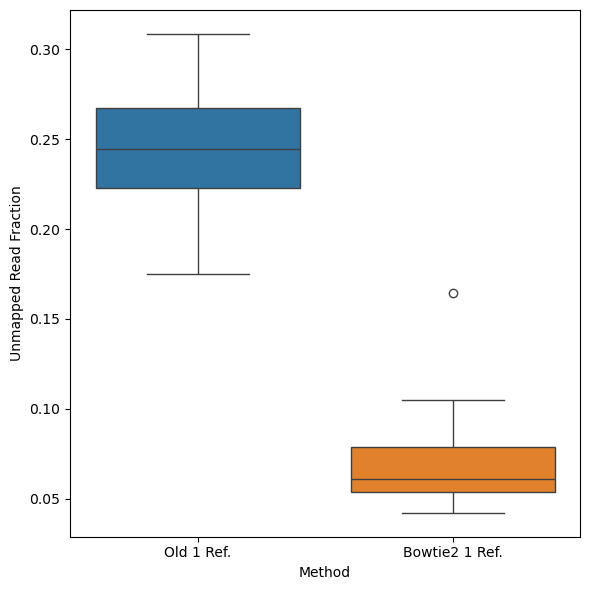

In [69]:
plt.figure(figsize=(6, 6))
sns.boxplot(df[df['Method'].isin({'Old 1 Ref.', 'Bowtie2 1 Ref.'})], x='Method', y='Unmapped Read Fraction', hue='Method')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

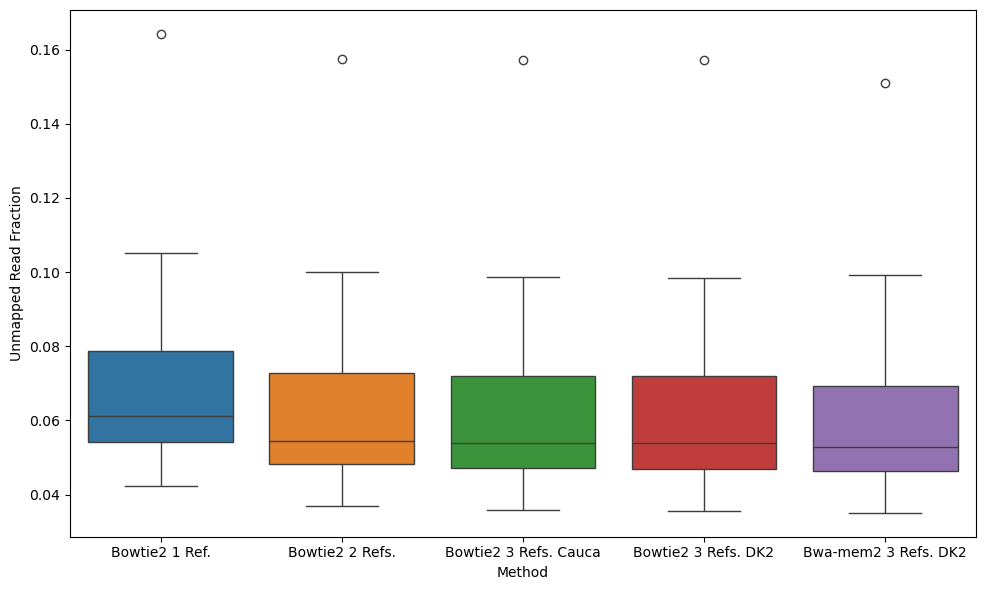

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(df[df['Method'] != 'Old 1 Ref.'], x='Method', y='Unmapped Read Fraction', hue='Method')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

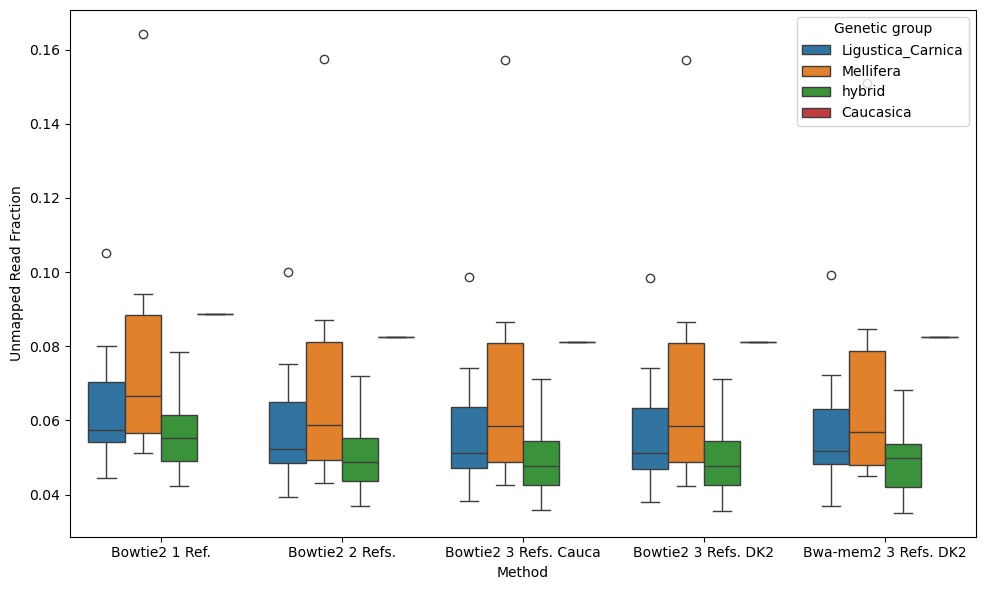

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(df[df['Method'] != 'Old 1 Ref.'], x='Method', y='Unmapped Read Fraction', hue='Genetic group')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

In [34]:
df[df['Method'] == 'Bowtie2 3 Ref. Genomes']

,Colony,Method,Unmapped Read Nr,Unmapped Read Fraction
2,BS16_0117,Bowtie2 3 Ref. Genomes,5321748,0.059905
5,BS17_0009,Bowtie2 3 Ref. Genomes,4916354,0.054683
8,BS16_0071,Bowtie2 3 Ref. Genomes,2621582,0.046400
11,BS17_1465,Bowtie2 3 Ref. Genomes,2146016,0.038123
14,BS17_0051,Bowtie2 3 Ref. Genomes,3139082,0.047554
17,BS17_0202,Bowtie2 3 Ref. Genomes,2352954,0.047209
20,BS17_0005,Bowtie2 3 Ref. Genomes,6814142,0.074041
23,BS17_0147,Bowtie2 3 Ref. Genomes,4686654,0.098431
26,BS17_0737,Bowtie2 3 Ref. Genomes,9211526,0.157070
29,BS18_0056,Bowtie2 3 Ref. Genomes,6652088,0.086602


In [30]:
df[df['Colony'] == 'BS17_0737']

,Colony,Method,Unmapped Read Nr,Unmapped Read Fraction
24,BS17_0737,Old 1 Ref.,17827446,0.303922
25,BS17_0737,Bowtie2 1 Ref. Genomes,9631026,0.164223
26,BS17_0737,Bowtie2 3 Ref. Genomes,9211526,0.157070


In [29]:
array_id2bs_id

{1: 'BS16_0117',
 2: 'BS17_0009',
 3: 'BS16_0071',
 4: 'BS17_1465',
 5: 'BS17_0051',
 6: 'BS17_0202',
 7: 'BS17_0005',
 8: 'BS17_0147',
 9: 'BS17_0737',
 10: 'BS18_0056',
 11: 'BS18_0073',
 12: 'BS17_0174',
 13: 'BS16_0413',
 14: 'BS18_0140',
 15: 'BS17_0446',
 16: 'BS16_0306',
 17: 'BS17_0485',
 18: 'BS17_0187',
 19: 'BS17_0095',
 20: 'BS16_0392'}

In [36]:
pheno_df[pheno_df['Colony'] == 'BS17_0737']

,Colony,date,Genetic group,percent_Ligustica_Carnica,percent_Mellifera,percent_Caucasica,bee_weigth,nbr_pho_varroa,nbr_pho_varroa_100bee,v_pho,v_mito,nbr_open,nbr_inf,nbr_bee,nbr_closed_brood,nbr_open_brood,nbr_male_brood,brood,v_load,pca1,nbr_open.1,nbr_recap_inf,recap_inf,Recapping,nbr_inf_1fondress,nbr_inf_norepro,percent_mnr,DMR,eb_mmr,Region,Department,Apiary,Year,Month,Day of Year,Latitude,Longitude,v_meta,log_v_meta,log_v_pho,log_v_mito,Varroa group,Recapping group,DMR group
924,BS17_0737,14/09/2017,Mellifera,0.069132,0.930114,0.000754,46.0,7.0,2.0,2.130435,0.049924,405.0,36.0,13413.0,7050.0,9300.0,0.0,16350.0,899.0,0.308727,405.0,28.0,0.088889,-2.302585,35.0,21.0,60.0,0.6,0.563702,corse,Haute_Corse,55.0,2017,9,257,42.467,9.2,0.00008,-9.433149,0.756326,-2.99726,High,Medium,High


## Kraken2

In [27]:
step_name = 'kraken2'
step_path = '{}{}/'.format(data_path, step_name)

bowtie2_path = '{}bowtie2_bee3ref/'.format(data_path)

kdb_path = '{}krakdb/'.format(shared_data_path)
kdb_name = 'corent'

kraken2_path = '{}kraken2/'.format(data_path)
bracken_path = '{}bracken/'.format(data_path)

read_pool = 'nonbee'
mhg = '2'
cs = '0.05' # --> need to test also a few values here

In [28]:
expected_file_suffixes = ['_{}_{}_mhg{}_cs{}_sf1_rep1.kraken2'.format(kdb_name, read_pool, mhg, str(cs).replace('.', '')), '_{}_{}_mhg{}_cs{}_sf1_rep1.k2report'.format(kdb_name, read_pool, mhg, str(cs).replace('.', ''))]
k2_jobs_to_run, k2_completed_jobs = get_jobs_to_restart(step_name, array_id2bs_id, array_id2bs_id, kraken2_path, expected_file_suffixes)
k2_jobs_to_run, k2_completed_jobs

([], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [74]:
# most efficient is actually to run things in home 
array_str = write_array_str(k2_jobs_to_run, min(len(k2_jobs_to_run), 2))
kraken2_script = '{}kraken2.run'.format(script_path)
write_kraken2_script(kraken2_script, array_str, read_pool, mhg, cs)
array_str

'2-20%2'

In [75]:
command = ['sbatch', kraken2_script, kdb_path, kdb_name, bowtie2_path, kraken2_path, bracken_path, bs_ids_file]
result = subprocess.run(command, cwd=kraken2_path, capture_output=False)

Submitted batch job 1409361


## unclassified proportion

In [8]:
   
def get_uc_read_nr(kraken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, bracken_path, level):
    kraken_ucread_nr, kraken_cread_nr = parse_kreport(kraken_path, bs_id, krakdb, readpool, mhg, cs, sf, r)
    return kraken_ucread_nr + kraken_cread_nr - parse_breport(bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, ['root'])['root']


In [72]:
level = 'F'

# want total read nr, classifed read nr, proportion of classified reads, number and proportion of non bee reads
krakdb, readpool, mhg, cs, sf, r, level = ('corent', 'nonbee', 2, '005', 1, 1, 'F')

columns = ['Colony', 'OLD Classified Read Nr. (Non-Bee)', 'OLD Classified Read Frac. (Non-Bee)', 'OLD Unclassified Read Nr.', 'OLD Unclassified Read Frac.', 
           'NEW Classified Read Nr. (Non-Bee)', 'NEW Classified Read Frac. (Non-Bee)', 'NEW Unclassified Read Nr.', 'NEW Unclassified Read Frac.']
rows = []
for bs_id in bs_id2array_id:  
    # new 
    idx_name = 'bee3ref'
    bowtie2_path = '{}bowtie2_{}/'.format(data_path, idx_name)
    kraken_path = '{}kraken2/'.format(data_path)
    bracken_path = '{}bracken/'.format(data_path)
    total_read_nr = get_total_read_nr_flagstat(bowtie2_path, bs_id, idx_name)
    new_taxa2seqnr = parse_breport(bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, ['root', 'Anthophila'])
    new_nb_c_nr = new_taxa2seqnr['root'] - new_taxa2seqnr['Anthophila']
    new_uc_nr = get_uc_read_nr(kraken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, bracken_path, level)

    # old
    bowtie2_path = '{}bowtie2_2025/'.format(data_path)
    kraken_path = '{}kraken2_2025/'.format(data_path)
    bracken_path = '{}bracken_2025/'.format(data_path)
    old_taxa2seqnr = parse_breport(bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, ['root', 'Anthophila'])
    old_nb_c_nr = old_taxa2seqnr['root'] - old_taxa2seqnr['Anthophila']
    old_uc_nr = get_uc_read_nr(kraken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, bracken_path, level)
    
    rows.append((
        bs_id, 
        old_nb_c_nr,
        old_nb_c_nr / (old_nb_c_nr + old_uc_nr),
        old_uc_nr,
        old_uc_nr / (old_nb_c_nr + old_uc_nr), 
        new_nb_c_nr,
        new_nb_c_nr / (new_nb_c_nr + new_uc_nr),
        new_uc_nr,
        new_uc_nr / (new_nb_c_nr + new_uc_nr), 
    ))
df = pd.DataFrame(data=rows, columns=columns)

In [73]:
df

,Colony,OLD Classified Read Nr. (Non-Bee),OLD Classified Read Frac. (Non-Bee),OLD Unclassified Read Nr.,OLD Unclassified Read Frac.,NEW Classified Read Nr. (Non-Bee),NEW Classified Read Frac. (Non-Bee),NEW Unclassified Read Nr.,NEW Unclassified Read Frac.
0,BS16_0117,2115943,0.295651,5040943,0.704349,1782564,0.673004,866103,0.326996
1,BS17_0009,2217724,0.263458,6200021,0.736542,1829727,0.752167,602882,0.247833
2,BS16_0071,1073526,0.227346,3648468,0.772654,863620,0.665121,434820,0.334879
3,BS17_1465,908630,0.259689,2590288,0.740311,797703,0.757387,255527,0.242613
4,BS17_0051,1181580,0.172422,5671261,0.827578,918849,0.602302,606714,0.397698
5,BS17_0202,1055835,0.253391,3110988,0.746609,864157,0.737200,308058,0.262800
6,BS17_0005,2382719,0.281434,6083622,0.718566,2019537,0.598620,1354115,0.401380
7,BS17_0147,1377105,0.286288,3433099,0.713712,1273241,0.545038,1062820,0.454962
8,BS17_0737,3038289,0.410292,4366896,0.589708,2836839,0.619672,1741129,0.380328
9,BS18_0056,2539382,0.336497,5007142,0.663503,2302560,0.697160,1000211,0.302840


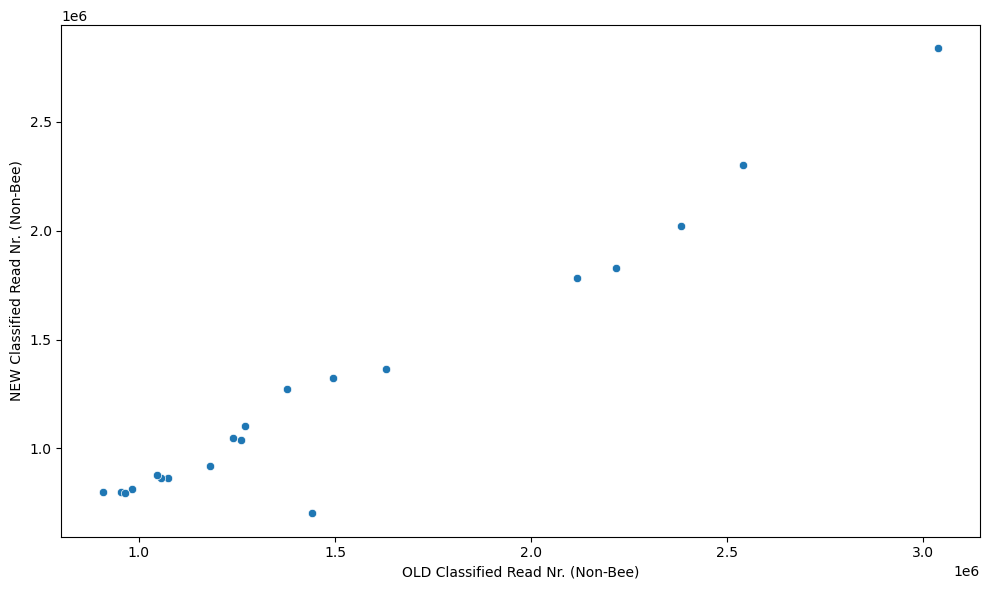

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='OLD Classified Read Nr. (Non-Bee)', y='NEW Classified Read Nr. (Non-Bee)')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

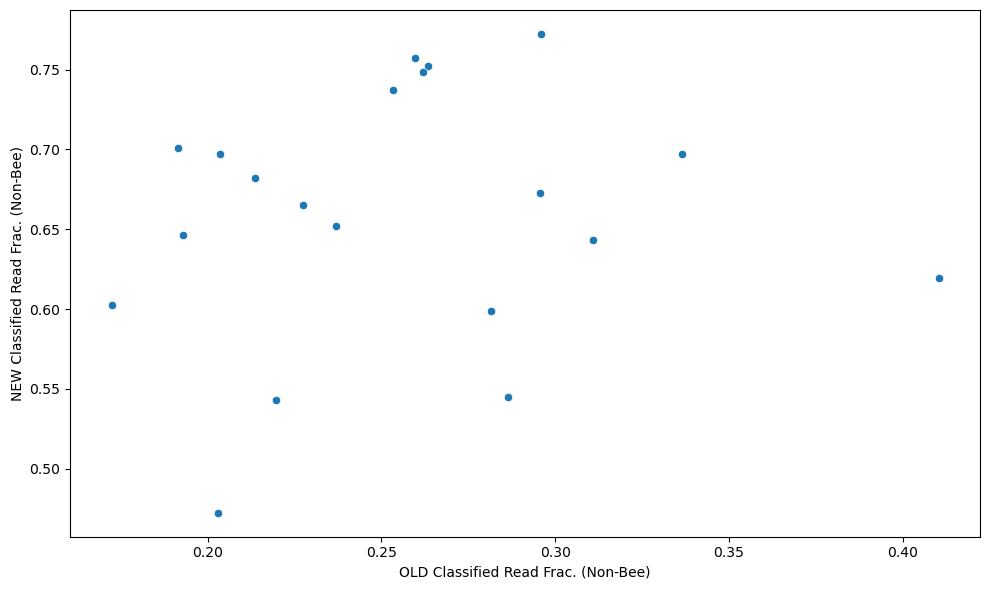

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='OLD Classified Read Frac. (Non-Bee)', y='NEW Classified Read Frac. (Non-Bee)')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

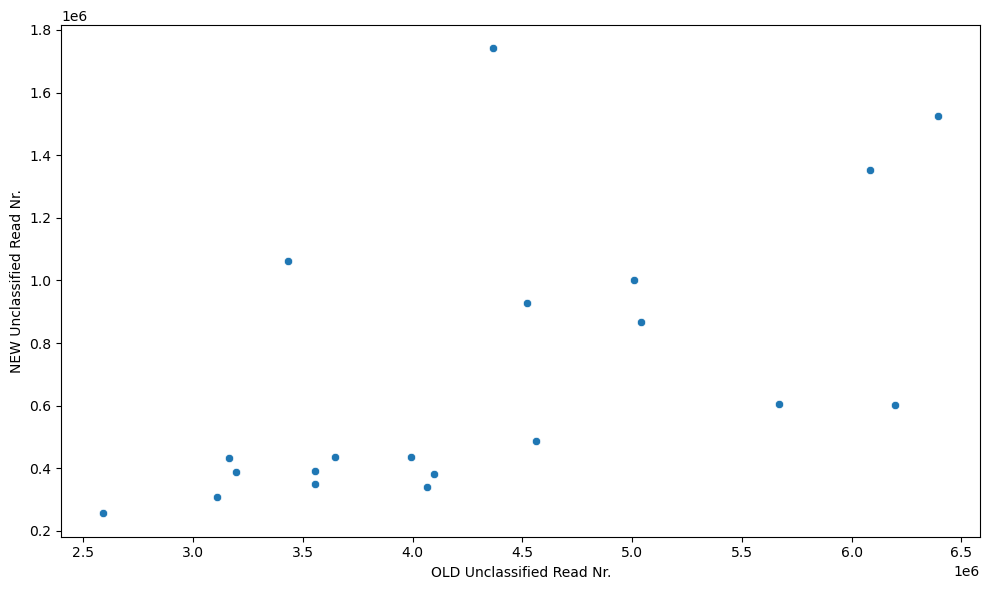

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='OLD Unclassified Read Nr.', y='NEW Unclassified Read Nr.')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

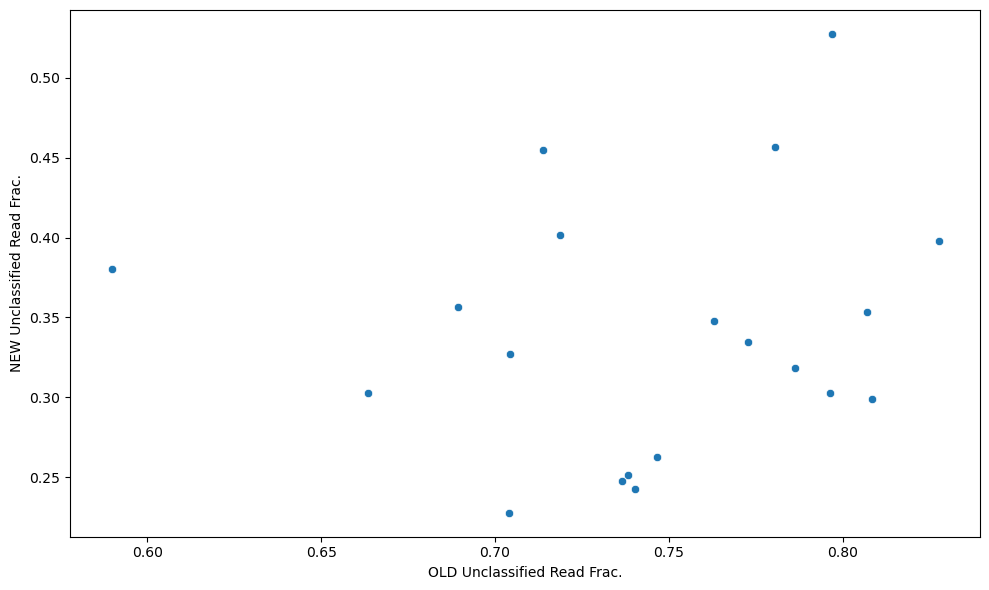

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='OLD Unclassified Read Frac.', y='NEW Unclassified Read Frac.')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

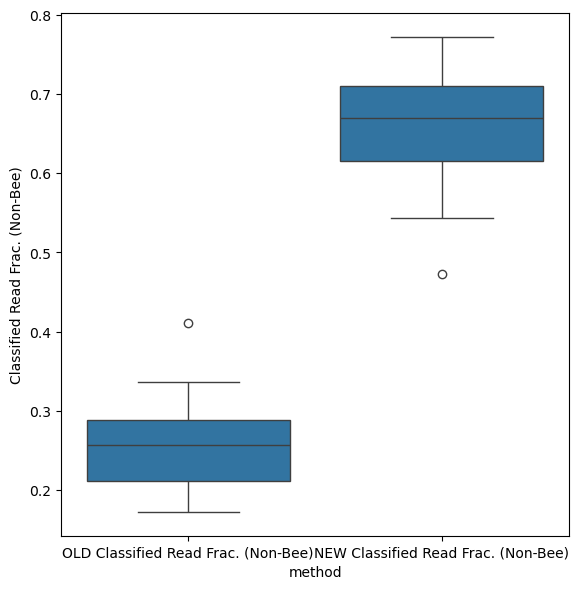

In [74]:
df_melt = df.melt(id_vars='Colony', value_vars=['OLD Classified Read Frac. (Non-Bee)', 'NEW Classified Read Frac. (Non-Bee)'], var_name='method', value_name='Classified Read Frac. (Non-Bee)')
plt.figure(figsize=(6, 6))
sns.boxplot(df_melt, x='method', y='Classified Read Frac. (Non-Bee)')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

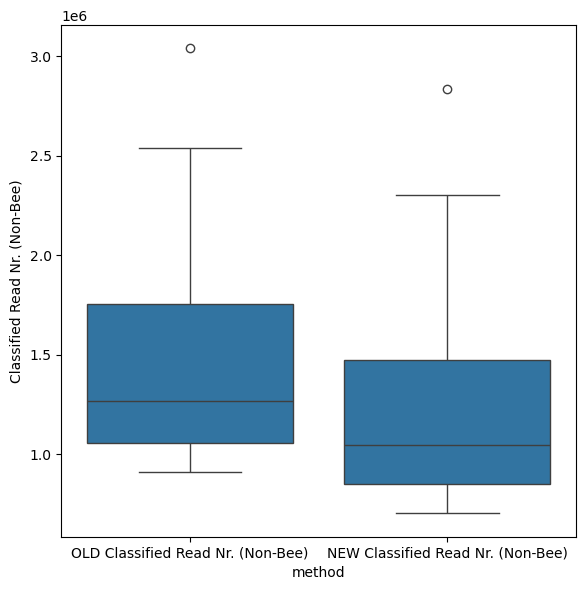

In [75]:
df_melt = df.melt(id_vars='Colony', value_vars=['OLD Classified Read Nr. (Non-Bee)', 'NEW Classified Read Nr. (Non-Bee)'], var_name='method', value_name='Classified Read Nr. (Non-Bee)')
plt.figure(figsize=(6, 6))
sns.boxplot(df_melt, x='method', y='Classified Read Nr. (Non-Bee)')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

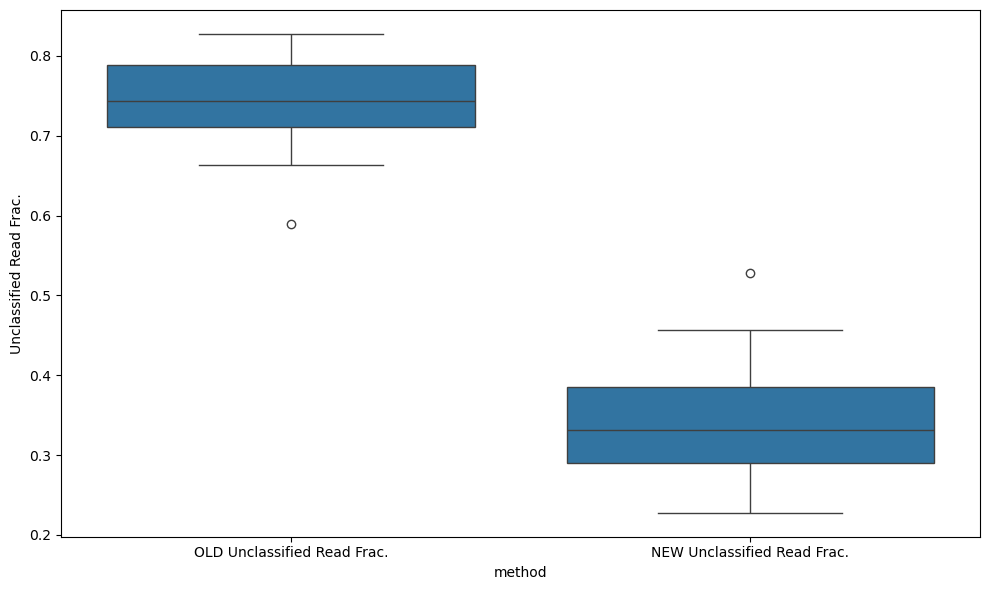

In [61]:
df_melt = df.melt(id_vars='Colony', value_vars=['OLD Unclassified Read Frac.', 'NEW Unclassified Read Frac.'], var_name='method', value_name='Unclassified Read Frac.')
plt.figure(figsize=(10, 6))
sns.boxplot(df_melt, x='method', y='Unclassified Read Frac.')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

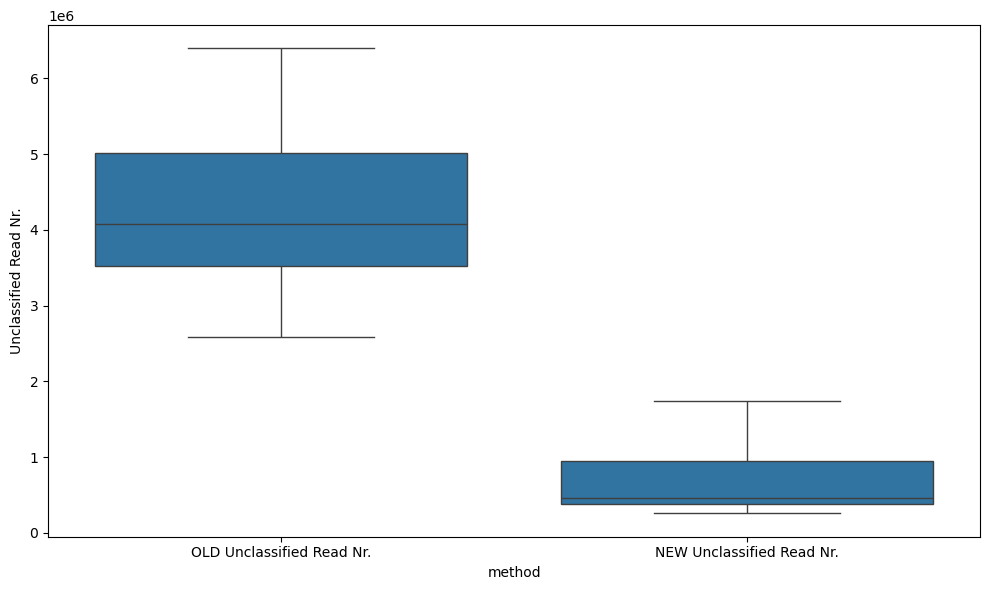

In [62]:
df_melt = df.melt(id_vars='Colony', value_vars=['OLD Unclassified Read Nr.', 'NEW Unclassified Read Nr.'], var_name='method', value_name='Unclassified Read Nr.')
plt.figure(figsize=(10, 6))
sns.boxplot(df_melt, x='method', y='Unclassified Read Nr.')
# plt.xticks(ticks=range(len(var2labels['Year'])), labels=var2labels['Year'], rotation=90, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel(trait_label, fontsize=12)
# plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

## relative abundances

In [9]:
def get_classified_read_nr(kraken_path, bracken_path, bs_id_str, krakdb, readpool, mhg, cs, sf, r, level, total_read_nr):
    '''
    Equals the total number of read in the raw fasta minus the number of unclassified reads by Bracken.
    For a subsample, I multiple the total number of reads by the sampling fraction (similar to subsampling reads before mapping with bowtie2)
    '''
    kraken_ucread_nr, kraken_cread_nr = parse_kreport(kraken_path, bs_id_str, krakdb, readpool, mhg, cs, sf, r)
    bracken_cread_nr = parse_breport(bracken_path, bs_id_str, krakdb, readpool, mhg, cs, sf, r, level, ['root'])['root']
    bracken_ucread_nr = kraken_cread_nr - bracken_cread_nr
    return sf * total_read_nr - kraken_ucread_nr - bracken_ucread_nr

def get_desc_taxa(node, cand_taxa):
    desc_taxa = []
    if node.sci_name in cand_taxa:
        desc_taxa.append(node.sci_name)
        return desc_taxa
    for ch in node.children:
        desc_taxa.extend(get_desc_taxa(ch, cand_taxa))
    return desc_taxa

def get_class_df(bs_ids, level, group_name2taxid, kraken2_path, bracken_path, bowtie2_path, new_bowtie2_path):
    krakdb, readpool, mhg, cs, sf, r, level = ('corent', 'nonbee', 2, '005', 1, 1, level)
    
    tree = ncbi.get_topology(list(group_name2taxid.values()))
    
    columns = ['Colony', 'Category', 'Read Number', 'Relative Abundance', 'Log Relative Abundance']
    rows = []
    for bs_id in tqdm(bs_ids):
        total_read_nr = get_total_read_nr_flagstat(new_bowtie2_path, bs_id, 'bee3ref')
        ucseqs_nr, cseqs_nr = parse_kreport(kraken2_path, bs_id, krakdb, readpool, mhg, cs, sf, r)
        taxa2seqnr = parse_breport(bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, taxonomic_groups)
        classified_read_nr = get_classified_read_nr(kraken2_path, bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, total_read_nr)

        rows.append((bs_id, 'Unclassified', ucseqs_nr))
        rows.append((bs_id, 'Kraken2 only', cseqs_nr - taxa2seqnr['root']))
        
        for taxon in taxonomic_groups:
            name = group2name.get(taxon, taxon)
            node = tree&group_name2taxid[name]
            read_nr = taxa2seqnr.get(taxon, 0) - sum([taxa2seqnr.get(x, 0) for x in get_desc_taxa(node, taxonomic_groups.difference({node.sci_name}))])

            # add pseudo count
            read_nr += 1
            classified_read_nr += 1 
            
            # add number of reads that aligned to bee genome (all minus the unmapped ones...)
            if taxon == 'Anthophila': 
                read_nr += (total_read_nr - ucseqs_nr - cseqs_nr)
            
            rel_abund = read_nr  / classified_read_nr
            rows.append((bs_id, name, read_nr, rel_abund, np.log(rel_abund)))
    
    return pd.DataFrame(data=rows, columns=columns)


In [5]:
from ete3 import NCBITaxa
ncbi = NCBITaxa(dbfile="/cluster/raid/home/f80878961/data/taxa.sqlite", update=False)

In [6]:
taxonomic_groups = set(('root', 'Viruses','Bacteria', 'Archaea', 'Eukaryota', 'Embryophyta', 'Fungi', 'Metazoa', 'Apidae','Varroidae'))
group2name = {'root': 'Other Root', 'Eukaryota': 'Other Eukaryota', 'Metazoa': 'Other Metazoa', 'Viruses': 'DNA viruses'}
group_name2taxid = {group2name.get(k, k): v[0] for k, v in ncbi.get_name_translator(taxonomic_groups).items()}

broad_taxa = ['Varroidae', 'Other Metazoa', 'Fungi', 'Embryophyta', 'Other Eukaryota', 'Bacteria', 'Archaea', 'DNA viruses']

In [12]:
bowtie2_path = '{}bowtie2_2025/'.format(data_path)
kraken2_path = '{}kraken2_2025/'.format(data_path)
bracken_path = '{}bracken_2025/'.format(data_path)
old_fam_class_df = get_class_df(bs_id2array_id, 'F', group_name2taxid, kraken2_path, bracken_path, bowtie2_path, '{}bowtie2_bee3ref/'.format(data_path))

100%|██████████| 20/20 [00:00<00:00, 66.13it/s]


In [13]:
old_fam_class_df.insert(1, 'Method', len(old_fam_class_df) * ['Old'])

In [14]:
bowtie2_path = '{}bowtie2_bee3ref/'.format(data_path)
kraken2_path = '{}kraken2/'.format(data_path)
bracken_path = '{}bracken/'.format(data_path)
new_fam_class_df = get_class_df(bs_id2array_id, 'F', group_name2taxid, kraken2_path, bracken_path, bowtie2_path, '{}bowtie2_bee3ref/'.format(data_path))

100%|██████████| 20/20 [00:00<00:00, 157.04it/s]


In [15]:
new_fam_class_df.insert(1, 'Method', len(new_fam_class_df) * ['New'])

In [16]:
fam_class_df = pd.concat([old_fam_class_df, new_fam_class_df])

In [17]:
fam_class_df

,Colony,Method,Category,Read Number,Relative Abundance,Log Relative Abundance
0,BS16_0117,Old,Unclassified,5026286,NaN,NaN
1,BS16_0117,Old,Kraken2 only,14657,NaN,NaN
2,BS16_0117,Old,Apidae,2468520,2.945911e-02,-3.524752
3,BS16_0117,Old,Other Root,3,3.580175e-08,-17.145269
4,BS16_0117,Old,Fungi,42354,5.054490e-04,-7.590063
...,...,...,...,...,...,...
235,BS16_0392,New,Other Metazoa,3065,4.374065e-05,-10.037233
236,BS16_0392,New,Embryophyta,7902,1.127695e-04,-9.090164
237,BS16_0392,New,Bacteria,1350338,1.927069e-02,-3.949170
238,BS16_0392,New,DNA viruses,1255,1.791012e-05,-10.930145


<Axes: xlabel='Category', ylabel='Relative Abundance'>

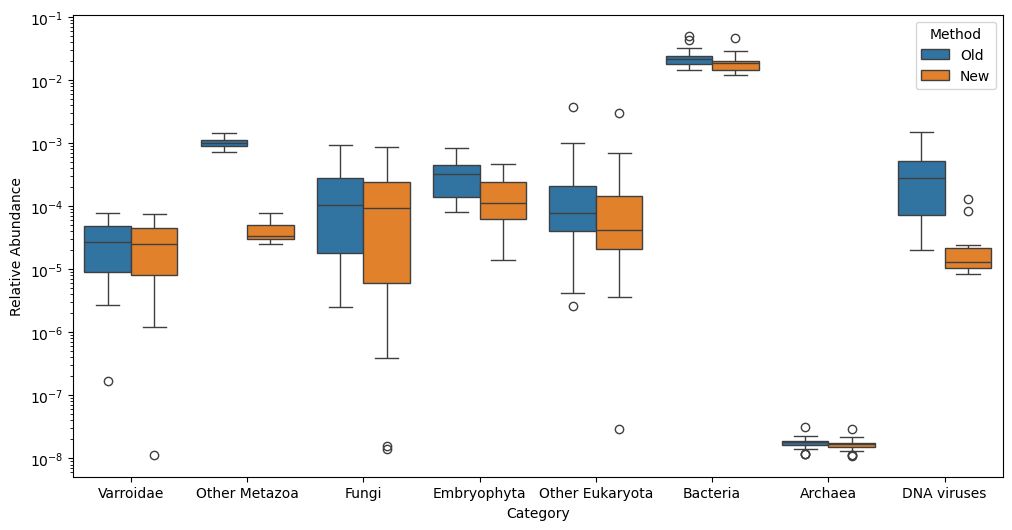

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=fam_class_df[fam_class_df['Category'].isin(broad_taxa)], hue='Method', x='Category', y='Relative Abundance', order=broad_taxa, legend=True, log_scale=True)

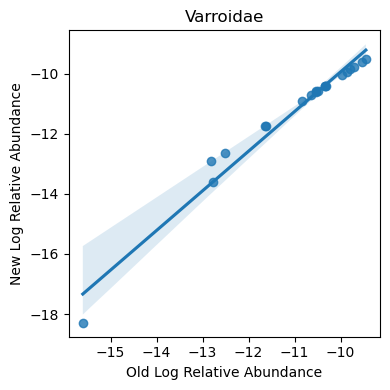

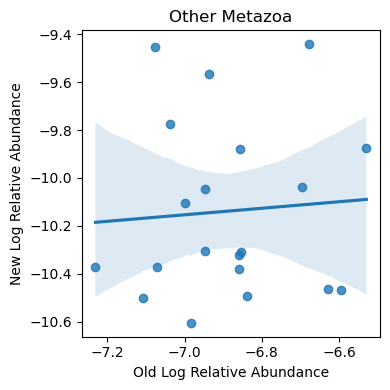

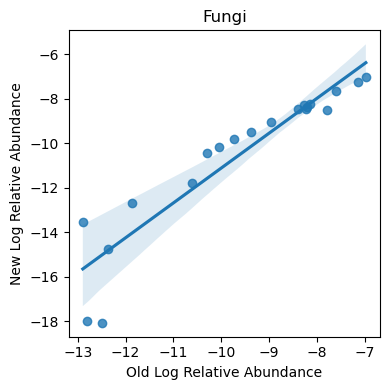

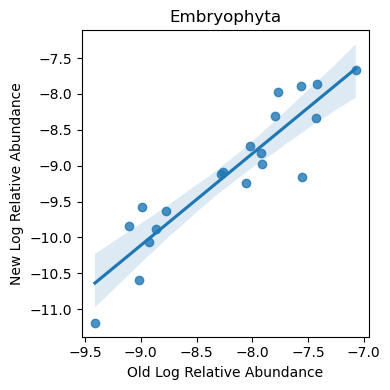

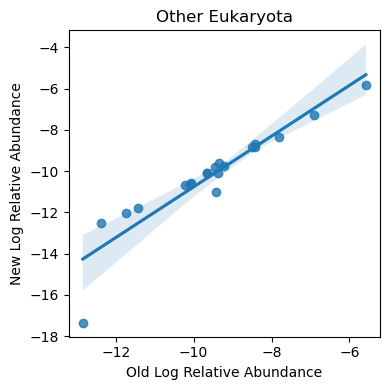

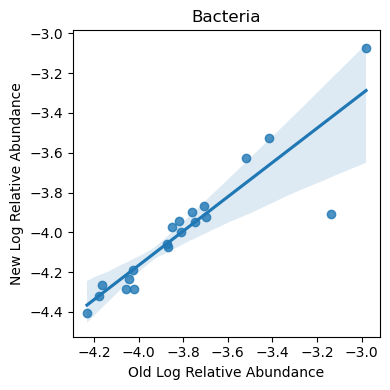

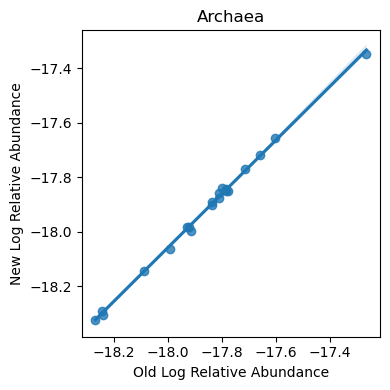

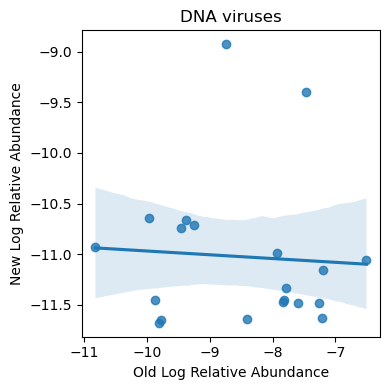

In [39]:
for taxon in broad_taxa:
    pivot_df = fam_class_df[fam_class_df['Category'] == taxon].pivot_table(values='Log Relative Abundance', index = 'Colony', columns='Method')
    plt.figure(figsize=(4, 4))
    ax = sns.regplot(pivot_df, x = 'Old', y = 'New')
    ax.set_title(taxon)
    ax.set_xlabel('Old Log Relative Abundance')
    ax.set_ylabel('New Log Relative Abundance')
    plt.tight_layout()
    plt.show()

## Final preprocessing pipeline

In [15]:
data_path = '/cluster/raid/home/f80878961/beestrong/01_preprocessing/'

# list of beestrong sample ids for array job
bs_ids_file = '{}sampled_bs_ids.txt'.format(data_path)
if not os.path.exists(bs_ids_file):
    write_bs_ids_file(bs_ids_file, pheno_df['Colony'])
array_id2bs_id, bs_id2array_id = read_bs_ids_file(bs_ids_file)

sra_path = '{}sra/'.format(data_path) 
fastq_path = '{}fastq/'.format(data_path)
sample_SRA_file = '{}sample_SRA.csv'.format(tlf_path)
bowtie2_path = '{}bowtie2/'.format(data_path)
idx_name = 'bee3ref_new'
idx_path = '{}{}_bt2idx/'.format(shared_data_path, idx_name)

step_name = 'pp_mapping'
script_path = "/cluster/raid/home/f80878961/scripts/tmp_scripts/"
expected_file_suffixes = ['_{}_mapped.flagstat'.format(idx_name), '_{}_unmapped.1.fastq.gz'.format(idx_name), '_{}_unmapped.2.fastq.gz'.format(idx_name)]

In [16]:
array_id2bs_id

{1: 'BS16_0001',
 2: 'BS16_0002',
 3: 'BS16_0003',
 4: 'BS16_0004',
 5: 'BS16_0005',
 6: 'BS16_0006',
 7: 'BS16_0007',
 8: 'BS16_0008',
 9: 'BS16_0009',
 10: 'BS16_0010',
 11: 'BS16_0011',
 12: 'BS16_0012',
 13: 'BS16_0013',
 14: 'BS16_0014',
 15: 'BS16_0015',
 16: 'BS16_0016',
 17: 'BS16_0017',
 18: 'BS16_0018',
 19: 'BS16_0019',
 20: 'BS16_0020',
 21: 'BS16_0021',
 22: 'BS16_0022',
 23: 'BS16_0023',
 24: 'BS16_0024',
 25: 'BS16_0025',
 26: 'BS16_0026',
 27: 'BS16_0027',
 28: 'BS16_0028',
 29: 'BS16_0029',
 30: 'BS16_0030',
 31: 'BS16_0031',
 32: 'BS16_0032',
 33: 'BS16_0033',
 34: 'BS16_0034',
 35: 'BS16_0035',
 36: 'BS16_0036',
 37: 'BS16_0037',
 38: 'BS16_0038',
 39: 'BS16_0039',
 40: 'BS16_0040',
 41: 'BS16_0041',
 42: 'BS16_0042',
 43: 'BS16_0043',
 44: 'BS16_0044',
 45: 'BS16_0045',
 46: 'BS16_0046',
 47: 'BS16_0047',
 48: 'BS16_0048',
 49: 'BS16_0049',
 50: 'BS16_0050',
 51: 'BS16_0051',
 52: 'BS16_0052',
 53: 'BS16_0053',
 54: 'BS16_0054',
 55: 'BS16_0055',
 56: 'BS16_0056',
 

In [17]:
pp_jobs_to_run, pp_completed_jobs = get_jobs_to_restart(
    step_name, array_id2bs_id, array_id2bs_id, bowtie2_path, expected_file_suffixes)
pp_jobs_to_run, pp_completed_jobs

([3,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
 

In [10]:
len(pp_completed_jobs)

101

In [56]:
pp_jobs_to_run

[4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187

In [18]:
pp_jobs_to_run = [3]

In [19]:
# most efficient is actually to run things in home 
array_str = write_array_str(pp_jobs_to_run[:100], min(32, len(pp_jobs_to_run))) # 32 * 8  = 256 (2 machine filled max) --> should do 100 jobs in 12h
pp_mapping_script = '{}{}.run'.format(script_path, step_name)
write_preprocessing_mapping_script(pp_mapping_script, array_str)
print(pp_mapping_script)
array_str

/cluster/raid/home/f80878961/scripts/tmp_scripts/pp_mapping.run


'3'

In [20]:
bs_ids_file, sra_path, fastq_path, sample_SRA_file, bowtie2_path, idx_path, idx_name

('/cluster/raid/home/f80878961/beestrong/01_preprocessing/sampled_bs_ids.txt',
 '/cluster/raid/home/f80878961/beestrong/01_preprocessing/sra/',
 '/cluster/raid/home/f80878961/beestrong/01_preprocessing/fastq/',
 '/cluster/raid/home/f80878961/beestrong/tlf/sample_SRA.csv',
 '/cluster/raid/home/f80878961/beestrong/01_preprocessing/bowtie2/',
 '/cluster/raid/home/f80878961/data/bee3ref_new_bt2idx/',
 'bee3ref_new')

In [21]:
command = ['sbatch', pp_mapping_script, bs_ids_file, sra_path, fastq_path, sample_SRA_file, bowtie2_path, idx_path, idx_name]
result = subprocess.run(command, cwd=bowtie2_path, capture_output=False)

Submitted batch job 1411471


In [12]:
bs_ids_file=$1
sra_path=$2
fastq_path=$3
sample_SRA_file=$4
bowtie2_path=$5
idx_path=$6
idx_name=$7

NameError: name 'bowtie2_path' is not defined

In [42]:
bowtie2_path

'/cluster/raid/home/f80878961/beestrong/01_preprocessing/bowtie2/'

# Custom Kraken2 database

In [1]:
from ete3 import NCBITaxa
from collections import Counter 
ncbi = NCBITaxa(dbfile="/cluster/raid/home/f80878961/.etetoolkit/taxa.sqlite")

In [2]:
corent_kdb_path = '/cluster/raid/home/f80878961/data/krakdb/corent/'
tax_fn = '{}ktaxonomy.tsv'.format(corent_kdb_path)
kdb_path = '/cluster/raid/home/f80878961/data/krakdb/custom/'

In [5]:
tid2name = ncbi.get_taxid_translator(pd.read_table(tax_fn)['1'].to_list())

In [6]:
%%time
tree = ncbi.get_topology(tid2name)

CPU times: user 2min 29s, sys: 17.5 s, total: 2min 46s
Wall time: 2min 50s


In [9]:
import pickle as pkl

In [10]:
%%time
# save tree...
with open('{}tree.pkl'.format(corent_kdb_path), 'wb') as outf:
    pkl.dump(tree, outf, protocol=pkl.HIGHEST_PROTOCOL)

CPU times: user 8.87 s, sys: 1.15 s, total: 10 s
Wall time: 12.7 s


In [ ]:
# load tree...

In [ ]:
# number of node per taxonomic rank --> class seems like a reasonable order to start sampling with ~ 500 genomes
rank_counts = Counter() 
for node in tree.traverse(): 
    if hasattr(node, "rank"): 
        rank_counts[node.rank] += 1
rank_counts

In [ ]:
%%time
#visusalize the class tree
class_tids = []
for n in tree.traverse():
    if n.rank == 'class':
        class_tids.append(n.taxid)
class_tree = ncbi.get_topology(class_tids)
for n in class_tree.traverse():
    n.name = n.sci_name
print(class_tree)

In [19]:
# sample based on refseq information
refseq_df = pd.read_table('{}assembly_summary_refseq.txt'.format(kdb_path), sep='\t', header=1)
tid2acc_ref_cat_size = {}
acc2tid = {}
for r in tqdm(refseq_df.iterrows()):
    tid2acc_ref_cat_size[r[1]['taxid']] = (r[1]['#assembly_accession'], r[1]['refseq_category'], r[1]['assembly_level'], r[1]['genome_size_ungapped'])
    acc2tid[r[1]['#assembly_accession']] = r[1]['taxid']

/tmp/ipykernel_4043728/3973455974.py:2: DtypeWarning: Columns (34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  refseq_df = pd.read_table('{}assembly_summary_refseq.txt'.format(kdb_path), sep='\t', header=1)
489238it [00:34, 14289.54it/s]


In [78]:
ctid2sampled_tid = {}

ref_priority = ['reference genome', 'na']
cat_priority = ['Chromosome', 'Complete Genome', 'Contig', 'Scaffold']

for n in tqdm(tree.traverse()):

    if tid2acc_ref_cat_size.get(n.taxid, None):
        acc, ref, cat, size = tid2acc_ref_cat_size[n.taxid]

        # finder the corresponding order
        ctid = set(n.lineage).intersection(class_tids)
        if len(ctid) != 1:
            continue
        ctid = list(ctid)[0]
        curr_tid = ctid2sampled_tid.get(ctid, None)
        
        # prioritize reference genomes, then highest quality, then longest
        if not curr_tid:
            ctid2sampled_tid[ctid] = n.taxid

        elif (ref_priority.index(ref) < ref_priority.index(tid2acc_ref_cat_size[curr_tid][1])):
            ctid2sampled_tid[ctid] = n.taxid

        elif (ref_priority.index(ref) == ref_priority.index(tid2acc_ref_cat_size[curr_tid][1])):
            if (cat_priority.index(cat) < cat_priority.index(tid2acc_ref_cat_size[curr_tid][2])):
                ctid2sampled_tid[ctid] = n.taxid

            elif (cat_priority.index(cat) == cat_priority.index(tid2acc_ref_cat_size[curr_tid][2])):
                if (size > tid2acc_ref_cat_size[curr_tid][3]):
                    ctid2sampled_tid[ctid] = n.taxid
len(ctid2sampled_tid)

2097016it [00:02, 812164.23it/s] 


In [80]:
sampled_tree = ncbi.get_topology(ctid2sampled_tid.values())
for n in sampled_tree.traverse():
    n.name = n.sci_name
print(sampled_tree)


                  /-Salinarchaeum laminariae
               /-|
              |   \-Methanoplanus limicola DSM 2279
              |
              |   /-Methanotorris igneus Kol 5
              |  |
              |--|--Methanobrevibacter ruminantium M1
              |  |
            /-|   \-Methanopyrus kandleri AV19
           |  |
           |  |--Thermococcus aggregans
           |  |
           |  |--Methanonatronarchaeum thermophilum
         /-|  |
        |  |  |--Ferroglobus placidus DSM 10642
        |  |  |
        |  |   \-Candidatus Methanoliparum sp. LAM-1
        |  |
        |   \-Ferroplasma acidarmanus Fer1
        |
        |      /-Saccharolobus caldissimus
        |   /-|
        |  |   \-Candidatus Korarchaeum cryptofilum OPF8
        |  |
        |--|   /-Candidatus Nitrosotalea okcheonensis
      /-|  |--|
     |  |  |   \-Conexivisphaera calida
     |  |  |
     |  |   \-Candidatus Bathycorpusculum sp.
     |  |
     |  |      /-Candidatus Nanopusillus massilien

In [88]:
rows = []
for tid in ctid2sampled_tid.values():
    rows.append((tid2acc_ref_cat_size[tid][0], tid))
# bee
rows.append((tid2acc_ref_cat_size[7460][0], 7460))
# varroa
rows.append((tid2acc_ref_cat_size[109461][0], 109461))

acc_tid_df = pd.DataFrame(rows)

In [ ]:
acc_tid_df.to_csv('/cluster/raid/home/f80878961/data/krakdb/custom/Accession_TaxID.txt', sep='\t', header=False, index=False)

acc_tid_df[0].to_csv('/cluster/raid/home/f80878961/data/krakdb/custom/Accession_names.txt', sep='\t', header=False, index=False)

### validate NCBI download

In [54]:
import glob

In [55]:
acc_tid_fn = '/cluster/raid/home/f80878961/data/krakdb/custom/Accession_TaxID.txt'
failed_acc_tid_fn = '/cluster/raid/home/f80878961/data/krakdb/custom/Accession_names_failed.txt'
genome_path = '/cluster/raid/home/f80878961/data/krakdb/custom/genomes/'

In [56]:
# rewrite Accession_TaxID.txt after wrongly deleted it
accs = [x.split('/')[-1] for x in glob.glob('{}GCF*'.format(genome_path))]
acc_tid_df = pd.DataFrame({0: accs, 1: [acc2tid[x] for x in accs]})
acc_tid_df.to_csv(acc_tid_fn, sep='\t', header=False, index=False)

In [ ]:
acc_tid_fn

In [57]:
with open(failed_acc_tid_fn, 'w') as outf:
    with open(acc_tid_fn, 'r') as inf:
        for l in inf:
            acc =  l.split()[0]
            if not os.path.exists('{}{}/ncbi_dataset/data/{}'.format(genome_path, acc, acc)):
                print(l)
                outf.write(acc + '\n')

In [44]:
for d in glob.glob('{}GCF*'.format(kdb_path)):
    acc = d.split('/')[-1]
    print(acc)
    os.remove('{}{}'.format(genome_path))

GCF_002105105.1
GCF_002217175.1
GCF_002443255.2
GCF_003254395.2
GCF_006345805.1
GCF_014066305.1
GCF_016086655.4
GCF_016835505.1
GCF_019059575.1
GCF_021730395.1
GCF_023864345.2
GCF_032191835.1
GCF_032884065.1
GCF_035770615.1
GCF_036898095.1
GCF_037975245.1
GCF_039555335.1
GCF_040869285.1
GCF_040938575.1
GCF_043290135.1
GCF_047496885.1
GCF_048772815.1
GCF_905237065.1
